In [527]:
from jupyter_client import find_connection_file
connection_file = find_connection_file()
print(connection_file)

/home/yonatan/.local/share/jupyter/runtime/kernel-v2-6096873X6bt0PYiF9.json


In [528]:
#Plotting related
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

# Scikit-learn related imports
import pyarrow
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, ttest_ind
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

In [529]:
df = pd.read_csv("../data/all_vaccines.csv")
df.head()

,Dataset,uid,geo_accession,biosample_accession,Donor,Age,IMMAGE,Gender,Virus,Vaccine,Strain,Day,Response,Cohort
0,GSE125921.SDY1529,SUB205386.1529,GSM3584988,NaN,YF00104002,27.0,0.193329,Male,Yellow Fever,YF-17D,Yellow Fever,D0,80.0,healthy aldults
1,GSE125921.SDY1529,SUB205386.1529,GSM3584988,NaN,YF00104002,27.0,0.193329,Male,Yellow Fever,YF-17D,Yellow Fever,FC,32.0,healthy aldults
2,GSE125921.SDY1529,SUB205386.1529,GSM3584988,NaN,YF00104002,27.0,0.193329,Male,Yellow Fever,YF-17D,Yellow Fever,D84,2560.0,healthy aldults
3,GSE125921.SDY1529,SUB205387.1529,GSM3584991,NaN,YF00104005,21.0,0.198895,Male,Yellow Fever,YF-17D,Yellow Fever,D0,80.0,healthy aldults
4,GSE125921.SDY1529,SUB205387.1529,GSM3584991,NaN,YF00104005,21.0,0.198895,Male,Yellow Fever,YF-17D,Yellow Fever,D84,1280.0,healthy aldults


In [530]:
dataset_col = "Dataset"
uid_col = "uid"
age_col = "Age"
day_col = "Day"
response_col = "Response"
immage_col = "IMMAGE"
strain_col = 'Strain'

current_dataset_num = 3

In [531]:
df[[dataset_col, uid_col, day_col]]

,Dataset,uid,Day
0,GSE125921.SDY1529,SUB205386.1529,D0
1,GSE125921.SDY1529,SUB205386.1529,FC
2,GSE125921.SDY1529,SUB205386.1529,D84
3,GSE125921.SDY1529,SUB205387.1529,D0
4,GSE125921.SDY1529,SUB205387.1529,D84
...,...,...,...
46494,SDY89,SUB114784.89,D28
46495,SDY89,SUB114784.89,D56
46496,SDY89,SUB114786.89,D196
46497,SDY89,SUB114786.89,D28


In [532]:
# drop missing values
df.dropna(inplace=True, subset=[immage_col, dataset_col, day_col, response_col])
dataset_names = df.Dataset.unique()

In [533]:
# Plot distribution of N values

N_vals = df[[dataset_col, uid_col]].groupby(dataset_col, as_index=False)[uid_col].nunique()
N_vals = N_vals.rename(columns={uid_col: "N"})
# sns.histplot(N_vals.N)

In [534]:
# Narrow N_v to large datasets only

N_vals = N_vals.loc[N_vals["N"]> 70]
datasets = df.loc[df["Dataset"].isin(N_vals["Dataset"])]
dataset_names = datasets["Dataset"].unique()
N_vals

,Dataset,N
6,GSE41080.SDY212,89
9,GSE48018.SDY1276,115
10,GSE48023.SDY1276,110
22,SDY67,159


In [535]:
# Examine available days per dataset
days = datasets[[dataset_col, uid_col, day_col]].groupby(dataset_col, as_index=False)[day_col].unique()
t = pd.Series(days.loc[[True, False, False, False], "Day"])
with pd.option_context('display.max_colwidth', None):
   for index, row in days.iterrows():
    print(f"Dataset: {row['Dataset']}\nDays: {row['Day']}\n\n")
 


Dataset: GSE41080.SDY212
Days: ['HAI.D0' 'FC.HAI' 'HAI.D28' 'HAI.maxRBA' 'HAI.RBA.Post' 'HAI.MFC.Post'
 'HAI.MFC']


Dataset: GSE48018.SDY1276
Days: ['nAb.D14' 'nAb.D28' 'nAb.D0' 'nAb.FC' 'HAI.D14' 'HAI.D28' 'HAI.D0'
 'HAI.FC' 'HAI.MFC' 'HAI.RBA.Post' 'HAI.MFC.Post' 'HAI.maxRBA']


Dataset: GSE48023.SDY1276
Days: ['nAb.FC' 'nAb.D0' 'nAb.D28' 'nAb.D14' 'HAI.FC' 'HAI.D14' 'HAI.D28'
 'HAI.D0']


Dataset: SDY67
Days: ['HAI.D0' 'HAI.MFC.Post' 'nAb.D0' 'nAb.D28' 'HAI.maxRBA' 'FC.D28.HAI'
 'HAI.D28' 'HAI.MFC' 'FC.D75.HAI' 'FC.D75.nAb' 'HAI.D3' 'nAb.D3'
 'FC.D28.nAb' 'HAI.D75' 'HAI.RBA.Post' 'nAb.D75']




In [536]:
# Collect day info from papers here
dataset_day_dict = {}

dataset_day_dict["GSE41080.SDY212"] = "HAI.D28"
dataset_day_dict["GSE48018.SDY1276"] = "nAb.D28"
dataset_day_dict["GSE48023.SDY1276"] = "nAb.D28"
dataset_day_dict["SDY67"] = "nAb.D28"
dataset_day_dict[dataset_names[0]]

'HAI.D28'

In [537]:
# Narrow to a specific dataset and day, then keep only relevant columns
dataset_name = dataset_names[0]
name_mask = datasets[dataset_col] == dataset_name
day_mask = datasets[day_col] == dataset_day_dict[dataset_name]

data = datasets.loc[(name_mask) & (day_mask)].reset_index()

# Somtimes there are multiple strains - so multiple rows per day
strains = data[strain_col].unique()
if len(strains) > 1:
   data = data.loc[data[strain_col] == strains[0]].reset_index()

# Take relevant columns only
data = data[[immage_col, response_col, age_col]]

dataset_name

'GSE41080.SDY212'

In [538]:
# Get a boolean map of sub and super threshold values

low_response_thr = data[[response_col]].quantile(q=0.3).item()
# high_response_thr = responses.quantile(q=0.7).item()  

# Generate labels
# Note that we define y=1 for all responses < 30th percentile (and not <=)
# Also note that we defined y=1 as *non* responders, since later on that's what we'll care most about detecting
data.loc[data[response_col] < low_response_thr, 'y'] = 1
data.loc[data[response_col] >= low_response_thr, 'y'] = 0
data.y = data.y.astype(int)

# Add a text label for plot legends
data['Label text'] = data['y'].apply(lambda x: 'Responders' if x == 0 else 'Non-Responders')
 
data

,IMMAGE,Response,Age,y,Label text
0,0.237785,160.0,24.07,0,Responders
1,0.155243,40.0,24.97,1,Non-Responders
2,0.112590,160.0,84.06,0,Responders
3,-0.100949,320.0,61.84,0,Responders
4,-0.226173,320.0,62.86,0,Responders
...,...,...,...,...,...
84,-0.128028,160.0,28.11,0,Responders
85,0.042327,1280.0,23.82,0,Responders
86,0.052453,320.0,20.68,0,Responders
87,0.193562,1280.0,84.28,0,Responders


In [539]:
print(f"Total N={data.shape[0]}")

Total N=89


In [540]:
# # sanity check for logistic regression - create a seperable dataset

# mask =  pd.Series(data['y'] == 1)
# counts = mask.value_counts()

# data.loc[~mask, immage_col] = np.random.uniform(low=0, high=0.4, size=[counts[False], 1])
# data.loc[mask, immage_col] = np.random.uniform(high=1, low=0.6, size=[counts[True], 1])
# # data = pd.concat([data, data[data["Labels"] == False].tail(3)], ignore_index=True)
dataset_name

'GSE41080.SDY212'

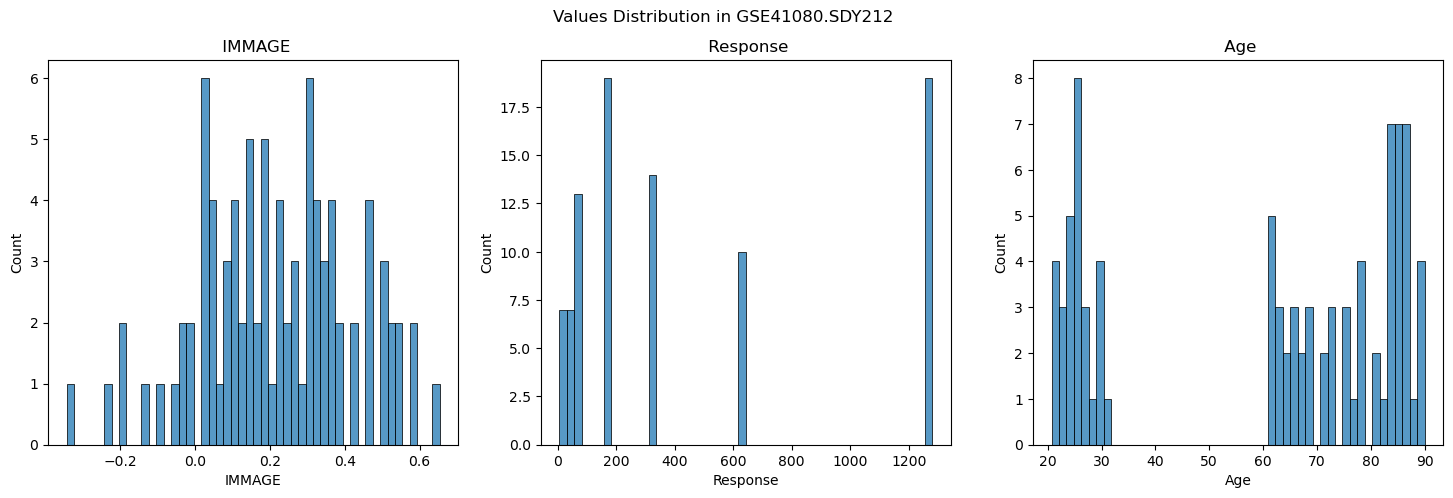

In [541]:
# Plot IMMAGE, response, and age values to look at the dynamic range
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjust figsize as needed
pd.concat
sns.histplot(data=data, x=immage_col, bins=50, ax=axs[0])
axs[0].set_title(f' {immage_col}')

sns.histplot(data=data, x=response_col, bins=50, ax=axs[1])
axs[1].set_title(f' {response_col}')

sns.histplot(data=data, x=age_col, bins=50, ax=axs[2])
axs[2].set_title(f' {age_col}')

fig.suptitle(f'Values Distribution in {dataset_name}')

plt.show()

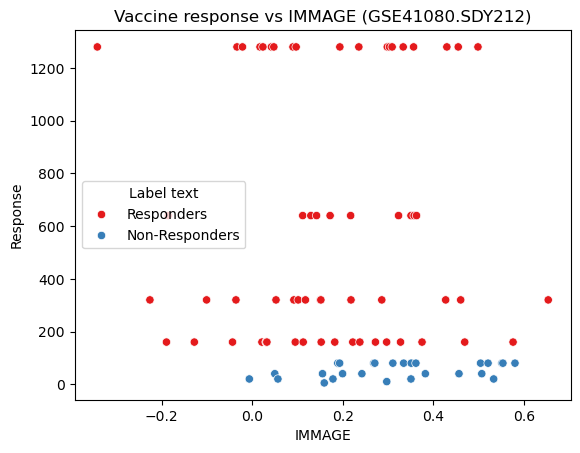

In [542]:
# Is there a trend like we expect?
# Plot the response value against sorted IMMAGE, with markers signifying labels
sorted_data = data.sort_values(by="IMMAGE")
sns.scatterplot(data=sorted_data, x="IMMAGE", y="Response", hue="Label text", palette='Set1')
plt.title(f'Vaccine response vs IMMAGE ({dataset_name})')
plt.show()

So we can already see that we won't be able to separate responders from non-responders. Later on, we'll try to get a threshold above which a certain proportion of subject didn't respond 

In [543]:
# Running a t-test
low_group = data.loc[data[response_col]  < low_response_thr, immage_col]
high_group = data.loc[data[response_col]  >= low_response_thr, immage_col]
print(f"low group N={low_group.shape[0]}, high group N={high_group.shape[0]}")

ttest = ttest_ind(low_group, high_group)
print(f"pvalue: {ttest.pvalue}")

low group N=27, high group N=62
pvalue: 0.001701136116823267


In [544]:
# Classifying with logistic regression
log_regress = LogisticRegression()
regression_result = cross_validate(log_regress, data[[immage_col]],  data["y"])
regression_result['test_score'].mean()

0.6967320261437908

In [545]:
# Split the data into training and testing sets
X_train, X_test, labels_train, labels_test = train_test_split(data[[immage_col]], data["y"], test_size=0.2, random_state=42)

log_regress.fit(data[[immage_col]],  data["y"])
# log_regress.score(X_test, labels_test)

beta_0 = log_regress.intercept_[0]
beta_1 = log_regress.coef_[0][0]


print(f'{beta_0}, {beta_1}')
# Calculate the cutoff value
cutoff = -beta_0 / beta_1

print(f"IMMAGE cutoff value is: {cutoff}")

-1.1868341182522089, 1.5536406787015242
IMMAGE cutoff value is: 0.7639051516365555


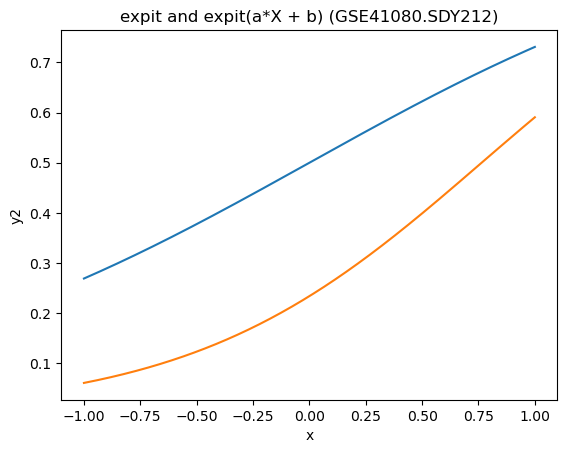

In [546]:
# Plot the logistic regression decision function
from scipy.special import expit
dft = pd.DataFrame()
dft["x"] = np.linspace(-1, 1, 500)
dft["y"] = beta_0 + dft.x * beta_1
dft["y2"] = expit(dft.x)
dft["y3"] = expit(dft.y)
sns.lineplot(data=dft, x="x", y="y2")
sns.lineplot(data=dft, x="x", y="y3")
plt.title(f'expit and expit(a*X + b) ({dataset_name})')
plt.show()

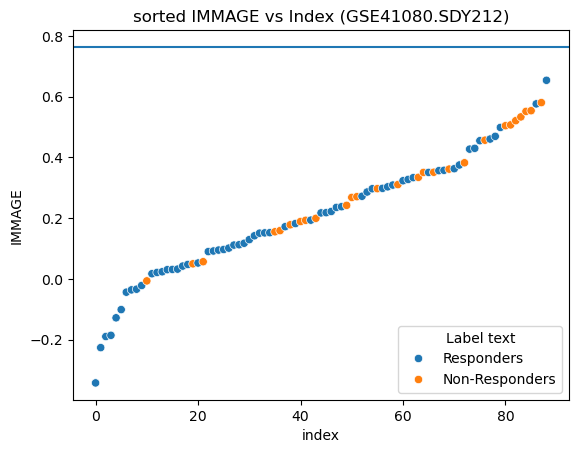

In [547]:
# Plot IMMAGE values and the cutoff
sns.scatterplot(data=data.sort_values(immage_col, ignore_index=True).reset_index(), x="index", y=immage_col, hue="Label text")
# commented out since cutoff is much higher and messes with the plot
plt.axhline(y=cutoff)
plt.title(f'sorted IMMAGE vs Index ({dataset_name})')
plt.show()

In [548]:
# Bin the data based on IMMAGE, look for a change in non-responder rate (proportion)

n_bins = 6
B = pd.cut(data["IMMAGE"], bins=n_bins, labels=range(n_bins))
data["bin"] = B.values.astype(int)

grouped = data.groupby("bin", as_index=False)['y'].mean().apply(lambda x: 1-x)
grouped.apply(print)
# for key, item in grouped:
#     print(grouped.get_group(key), "\n\n")

0    1
1    0
2   -1
3   -2
4   -3
5   -4
Name: bin, dtype: int64
0    1.000000
1    1.000000
2    0.846154
3    0.583333
4    0.684211
5    0.300000
Name: y, dtype: float64


bin    None
y      None
dtype: object

Logistic regreesion performs badly, but maybe it still assigns probabilities in a way that makes sense?

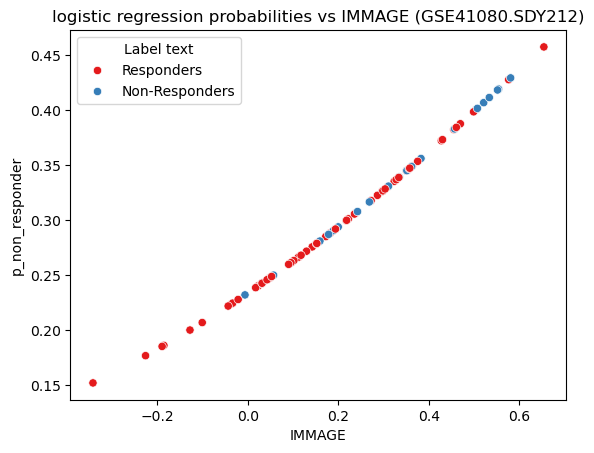

In [549]:
proba = pd.DataFrame(log_regress.predict_proba(data[["IMMAGE"]]))
proba
data["p_non_responder"] = proba[1]
# data["p_non_responder"].hist()
# data.plot.scatter(immage_col, "p_non_responder")

sns.scatterplot(data=data, x="IMMAGE", y="p_non_responder", hue="Label text", palette='Set1')
plt.title(f'logistic regression probabilities vs IMMAGE ({dataset_name})')
plt.show()

So we see that higher IMMAGE are associated with a higher probability of *not* responding. That's a good sign that the regressor picked up on an underlying dynamic in the direction that we were expecting.

Since this is the case, maybe an ROC curve where we shift the decision threshold based on probability will still work. (The default for log. reg. is to put the decision boundary at p=0.5)

optimal threshold:  0.28 (IMMAGE value)


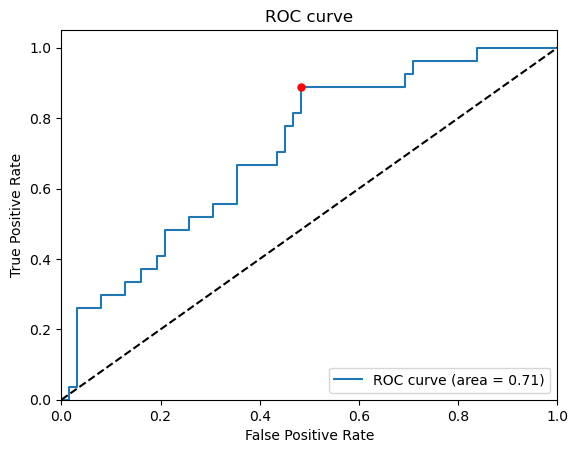

In [550]:
from sklearn.metrics import auc, roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(data["y"], data["p_non_responder"])
roc_auc = auc(fpr, tpr)

# Identifying the optimal threshold (example using Youden’s Index)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"optimal threshold: {optimal_threshold : 0.2f} (IMMAGE value)")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.plot(fpr[optimal_idx], tpr[optimal_idx], marker='o', markersize=5, color="red")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

An alternative is to try hard IMMAGE-based thresholds:


optimal threshold:  0.50 (IMMAGE value)


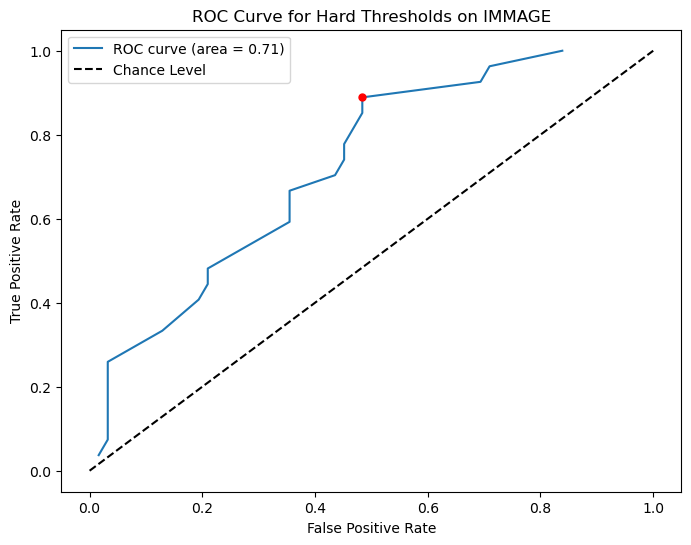

In [552]:
# Manually create threshold values. Only take y=1 (non-responders) as thresholds.
sorted_values = pd.DataFrame(pd.unique(data.loc[data["y"] == 1, immage_col])).sort_values(by=0)
thresholds = sorted_values[0]
roc_points = []

for t in thresholds:
    # Binary predictions based on the current threshold
    y_pred = (data[immage_col] >= t).astype(int)

    # Calculate TPR and FPR for the current set of binary predictions.
    # When roc_curve is given a binary array instead of probabilities, it calculates the fpr and tpr for the single threshold that they represent
    fpr, tpr, _ = roc_curve(data["y"], y_pred)
    roc_points.append((fpr[1], tpr[1]))  # Assuming single threshold; fpr and tpr have two elements


# Separate FPR and TPR values for plotting
fprs, tprs = zip(*roc_points)
fpr = pd.DataFrame(fprs).values
tpr = pd.DataFrame(tprs).values

# Identifying the optimal threshold (example using Youden’s Index)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"optimal threshold: {optimal_threshold : 0.2f} (IMMAGE value)")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], marker='o', markersize=5, color="red")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hard Thresholds on IMMAGE')
plt.legend()
plt.show()